# Задание 2

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pmdarima as pm
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from prophet import Prophet
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
NOV_data = yf.Ticker('NOV')
NOV_df = NOV_data.history(period='1d', start='2017-1-1', end='2022-10-18')
NOV_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03,36.767162,37.355515,35.870167,36.468166,4086300,0.0,0
2017-01-04,36.429586,37.423031,36.342780,37.162613,3242000,0.0,0
2017-01-05,37.288010,37.596653,36.960076,37.297653,2946100,0.0,0
2017-01-06,37.297650,37.808843,36.767169,37.606297,2916200,0.0,0
2017-01-09,37.201196,37.750967,36.603200,36.718941,3266900,0.0,0


Сформируем датасет с ценами закрытия, при этом прологорифмируем исходные значения для выравнивания значений ряда, уменьшения значений и разброса между данными, а также чтобы немного уменьшить тренд:


In [3]:
NOV_df = pd.DataFrame(NOV_df['Close']).asfreq('d').ffill()
NOV_df = np.log(NOV_df)
NOV_df.head()

,Close
Date,
2017-01-03,3.596440
2017-01-04,3.615303
2017-01-05,3.618930
2017-01-06,3.627171
2017-01-07,3.627171


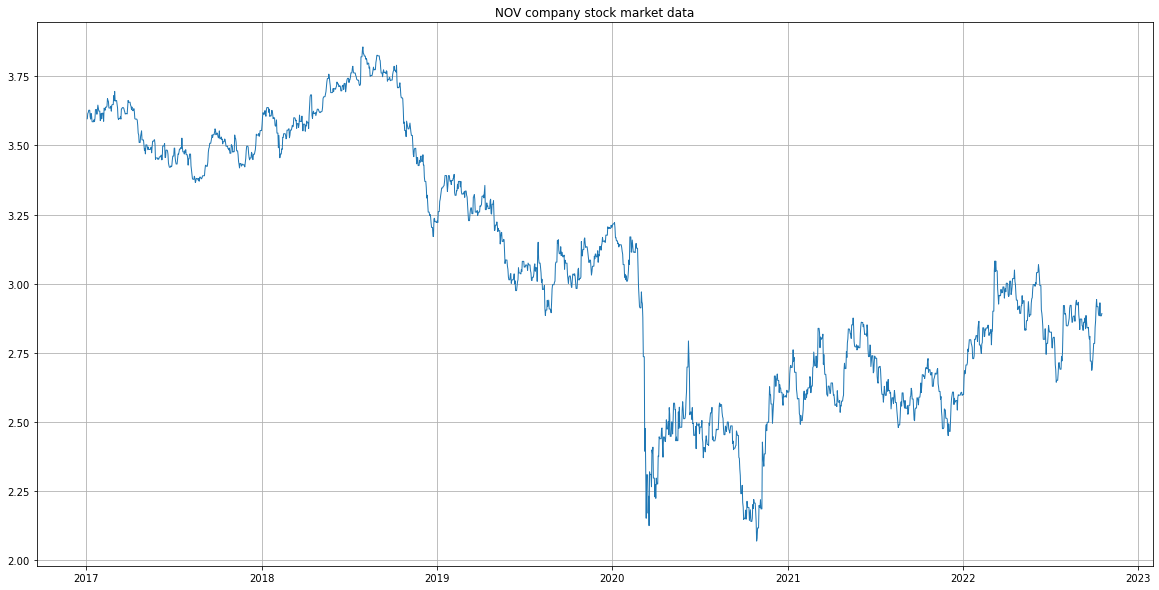

In [4]:
plt.figure(figsize=(20,10))
plt.plot(NOV_df.Close, linewidth='1')
plt.grid(True)
plt.title('NOV company stock market data');

In [5]:
train = pd.DataFrame(NOV_df['Close'][0:int(len(NOV_df)*0.80)])
test = pd.DataFrame(NOV_df['Close'][int(len(NOV_df)*0.80): int(len(NOV_df))])
print('Train shape: ',train.shape,'. Test shape: ',test.shape)

Train shape:  (1691, 1) . Test shape:  (423, 1)


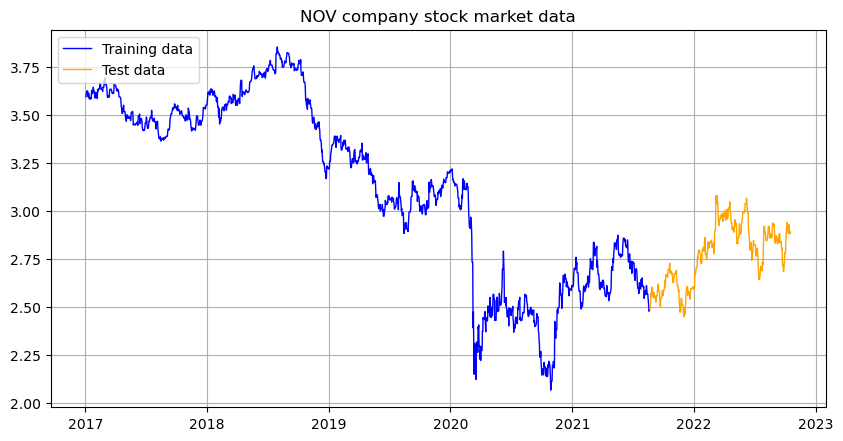

In [6]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, color = 'blue', label='Training data',linewidth=1)
plt.plot(test, color = 'orange', label='Test data',linewidth=1)
plt.title('NOV company stock market data')
plt.grid(True)
plt.legend(loc='upper left', fontsize=10)
plt.show()

Построим модель ARIMA, подобрав значения p и q самостоятельно. Для этого посмотрим на коррелограммы ACF и PACF для ряда первых разностей. 

### ARIMA

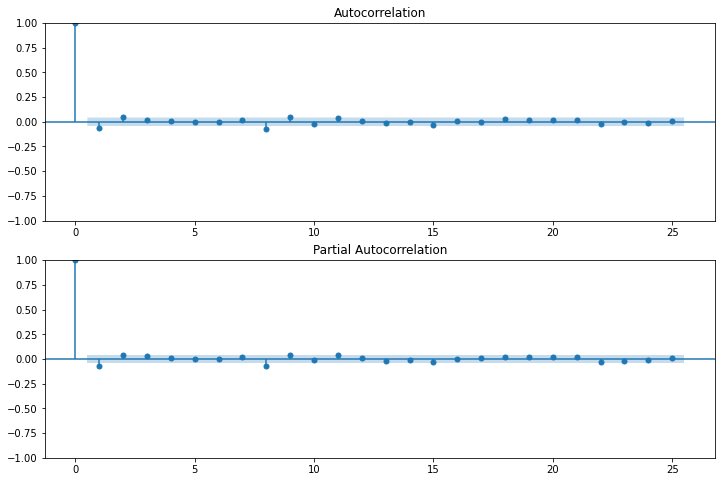

In [7]:
NOV_transform = NOV_df.diff(periods=1).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(NOV_transform[1:].values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(NOV_transform[1:], lags=25, ax=ax2)

Из PACF можно сделать вывод, что p = 1, поскольку на ней только 1 лаг сильно отличнен от нуля. По ACF можно увидеть, что q = 1, поскольку на ней тоже только 1 лаг сильно отличнен от нуля.

In [8]:
model_ARIMA = ARIMA(train, order=(1,1,1), trend = [0,1,1,1], freq='1d').fit()
model_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1691
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3664.332
Date:                Sun, 23 Oct 2022   AIC                          -7316.665
Time:                        17:33:07   BIC                          -7284.070
Sample:                    01-03-2017   HQIC                         -7304.595
                         - 08-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.003      0.150      0.881      -0.006       0.007
x2         -1.613e-06   3.51e-06     -0.459      0.646   -8.49e-06    5.27e-06
x3          5.573e-10   1.24e-09      0.448      0.654   -1.88e-09    2.99e-09
ar.L1         -0.3752    7.5e-05  -5001.613      0.000      -0.375      -0.375
ma.L1          0.2786   7.31e-05   3811.297      0.000       0.278       0.279
sigma2         0.0008   7.69e-06     99.858      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38360.67
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+19. Standard errors may be unstable.
"""

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

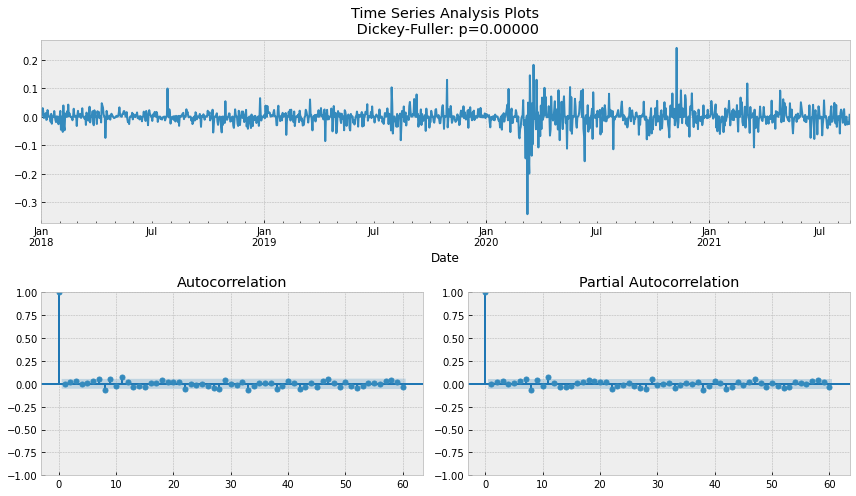

In [10]:
tsplot(model_ARIMA.resid['2018-01-01':], lags=60)

Остатки модели стационарны, значит можем приступать к построению прогноза:

In [11]:
train_predictions = model_ARIMA.predict(start=train.index[0], end=train.index[-1])
test_predictions = model_ARIMA.predict(start=test.index[0], end=test.index[-1])

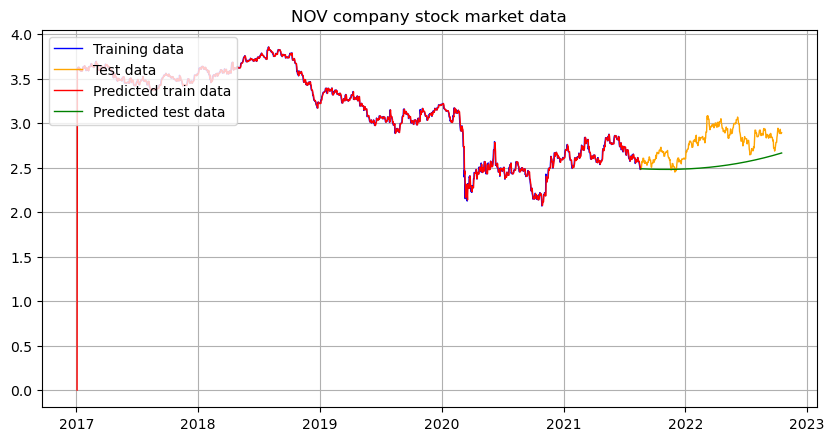

In [12]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, color = 'blue', label='Training data',linewidth=1)
plt.plot(test, color = 'orange', label='Test data',linewidth=1)
plt.plot(train_predictions, color = 'red', label='Predicted train data',linewidth=1)
plt.plot(test_predictions, color = 'green', label='Predicted test data',linewidth=1)
plt.title('NOV company stock market data')
plt.grid(True)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
train_error = mean_absolute_percentage_error(train['Close'], train_predictions)
test_error = mean_absolute_percentage_error(test['Close'], test_predictions)
print("Train Mean Absolute Percentage Error: {0:.2f}%".format(train_error))
print("Test Mean Absolute Percentage Error: {0:.2f}%".format(test_error))

Train Mean Absolute Percentage Error: 0.60%
Test Mean Absolute Percentage Error: 8.76%


Из графика и метрик видно, что модель хорошо запомнила данные на учебной выборке, но на тестовой выборке прогноз не совсем хороший. Для улучшения качества прогноза попробуем воспользоваться автоматическим подбором параметров.

### AUTO ARIMA

In [15]:
model_auto_arima = pm.auto_arima(train["Close"], 
                      max_p=6, max_q=5,
                      seasonal=True, 
                      m=12,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)


model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-7314.496, Time=2.02 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-7305.438, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-7318.596, Time=0.54 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-7317.075, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-7306.501, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-7320.267, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-7318.604, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-7316.503, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-7321.282, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-7319.697, Time=0.71 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=-7319.705, Time=0.74 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-7317.662, Time=0.83 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=-7320.108, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-7320.382, Time=0.53 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1691
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3664.114
Date:                Sun, 23 Oct 2022   AIC                          -7322.228
Time:                        17:33:59   BIC                          -7305.931
Sample:                    01-03-2017   HQIC                         -7316.193
                         - 08-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0948      0.014     -6.926      0.000      -0.122      -0.068
ar.L2          0.0429      0.013      3.298      0.001       0.017       0.068
sigma2         0.0008   7.42e-06    103.203      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             37970.84
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               7.54   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
train_auto_predictions = model_auto_arima.predict_in_sample(start=1, end=-1)
test_auto_predictions, test_auto_conf_interval = model_auto_arima.predict(n_periods=test.shape[0], return_conf_int=True)


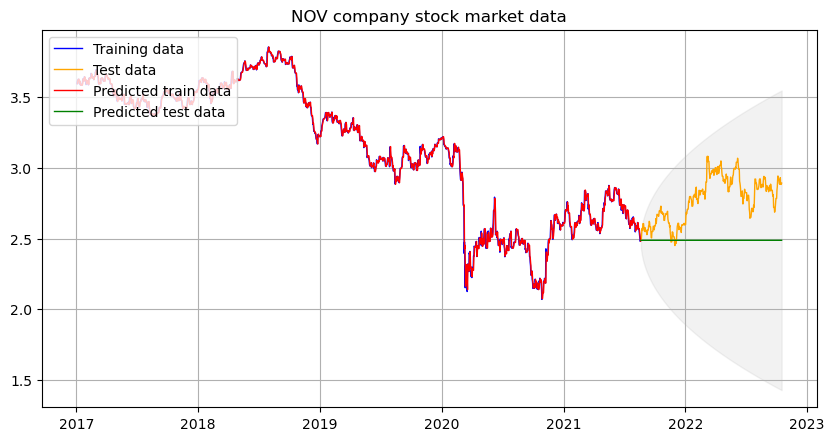

In [17]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, color = 'blue', label='Training data',linewidth=1)
plt.plot(test, color = 'orange', label='Test data',linewidth=1)
plt.plot(train_auto_predictions, color = 'red', label='Predicted train data',linewidth=1)
plt.plot(test_auto_predictions, color = 'green', label='Predicted test data',linewidth=1)
plt.fill_between(test.index, test_auto_conf_interval[:,0], test_auto_conf_interval[:, 1], color='grey', alpha=0.1)
plt.title('NOV company stock market data')
plt.grid(True)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [18]:
train_auto_error = mean_absolute_percentage_error(train['Close'], train_auto_predictions)
test_auto_error = mean_absolute_percentage_error(test['Close'], test_auto_predictions)
print("Train Mean Absolute Percentage Error: {0:.2f}%".format(train_auto_error))
print("Test Mean Absolute Percentage Error: {0:.2f}%".format(test_auto_error))

Train Mean Absolute Percentage Error: 0.54%
Test Mean Absolute Percentage Error: 10.25%


Из графика и метрик видно, что модель еще лучше запомнила данные на учебной выборке, но на тестовой выборке прогноз даже ухудшился. Для улучшения качества прогноза попробуем воспользоваться Facebook Prophet. 

### Facebook Prophet

In [19]:
df = NOV_df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2017-01-03,3.596440
1,2017-01-04,3.615303
2,2017-01-05,3.618930
3,2017-01-06,3.627171
4,2017-01-07,3.627171


In [20]:
train_spec = df[0:int(len(df)*0.80)]
test_spec = df[int(len(df)*0.80): int(len(df))]
print('Train shape: ',train_spec.shape,'. Test shape: ',test_spec.shape)

Train shape:  (1691, 2) . Test shape:  (423, 2)


In [22]:
model_fb = Prophet(daily_seasonality = True,
                   changepoint_prior_scale = 0.7,
                   holidays_prior_scale = 0.7,
                   n_changepoints = 20,
                   seasonality_mode = 'additive').fit(train_spec)


train_future = model_fb.make_future_dataframe(periods = 0, freq = "d", include_history = True)
test_future = model_fb.make_future_dataframe(periods = test_spec.shape[0], freq = "d", include_history = False)

train_forecast = model_fb.predict(train_future)
test_forecast = model_fb.predict(test_future)


17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:26 - cmdstanpy - INFO - Chain [1] done processing


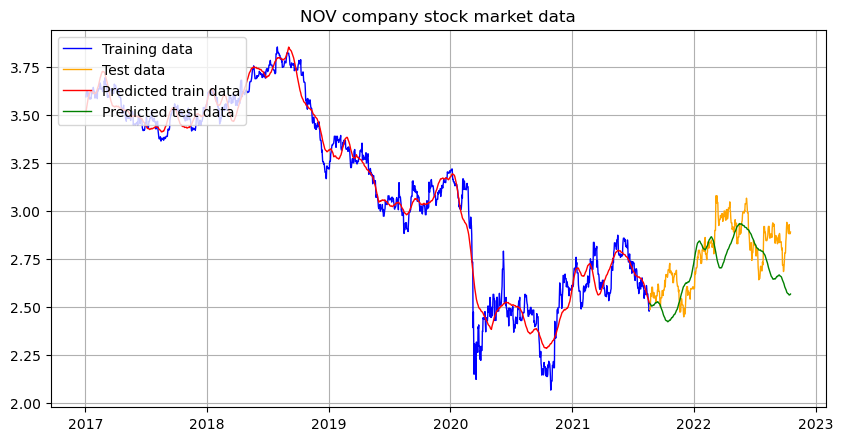

In [23]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_spec['ds'],train_spec['y'], color = 'blue', label='Training data',linewidth=1)
plt.plot(test_spec['ds'],test_spec['y'], color = 'orange', label='Test data',linewidth=1)
plt.plot(train_forecast['ds'],train_forecast['yhat'], color = 'red', label='Predicted train data',linewidth=1)
plt.plot(test_forecast['ds'],test_forecast['yhat'], color = 'green', label='Predicted test data',linewidth=1)
plt.title('NOV company stock market data')
plt.grid(True)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [24]:
train_auto_error = mean_absolute_percentage_error(train_spec['y'].values, train_forecast['yhat'].values)
test_auto_error = mean_absolute_percentage_error(test_spec['y'].values, test_forecast['yhat'].values)
print("Train Mean Absolute Percentage Error: {0:.2f}%".format(train_auto_error))
print("Test Mean Absolute Percentage Error: {0:.2f}%".format(test_auto_error))

Train Mean Absolute Percentage Error: 1.94%
Test Mean Absolute Percentage Error: 4.40%


Facebook Prophet по сравнению с предыдущими моделями отрабатывает лучше на тестовой выборке, а также внешне пытается предугадать тренд и сезонность (вид тестовой выборки). Но при этом не запоминает все значения учебной выборки, как предыдущие модели, а только общее сглаженное представление временного ряда.